In [68]:
import torch
import numpy as np
import cv2
from dcnet import DCNet
from dataset_utility import ToTensor
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import torch.nn.functional as F

In [219]:
# Load sample
# path = 'dataset/RAVEN-10000/distribute_nine/RAVEN_3149_test.npz'
# path = 'dataset/RAVEN-10000-fixed/distribute_four/RAVEN_929_test.npz'
path = 'center_single/RAVEN_1228_test.npz'
# path = 'RAVEN_929_test.npz'
data = np.load(path)
images = data['image']  # (16, 160, 160)

### Display the question

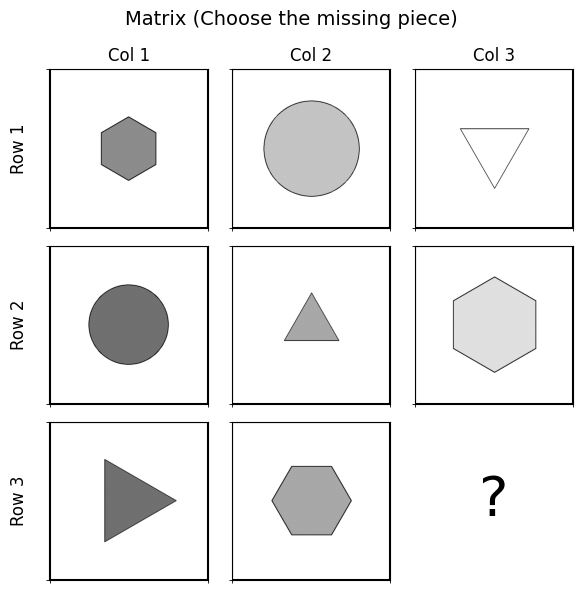

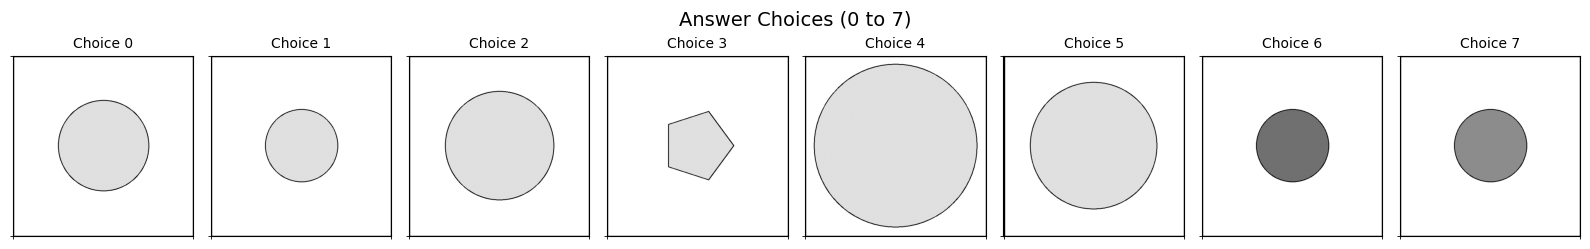

In [220]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
for i in range(8):
    ax = axs[i // 3, i % 3]
    ax.imshow(images[i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks([0, images[i].shape[1]], minor=True)
    ax.set_yticks([0, images[i].shape[0]], minor=True)
    ax.grid(which='minor', color='black', linewidth=1.5)

# Add the "?" in the missing cell (bottom-right)
ax = axs[2, 2]
ax.axis('off')
ax.text(0.5, 0.5, '?', transform=ax.transAxes, fontsize=40, ha='center', va='center')

# Add row and column labels
for row in range(3):
    axs[row][0].set_ylabel(f"Row {row+1}", fontsize=12, labelpad=10)
for col in range(3):
    axs[0][col].set_title(f"Col {col+1}", fontsize=12)

plt.suptitle('Matrix (Choose the missing piece)', fontsize=14)
plt.tight_layout()
# plt.savefig('matrix.png', dpi=1200)
plt.show()

# ---- Display the 8 answer choices ----
fig, axs = plt.subplots(1, 8, figsize=(16, 2.5))
for i in range(8):
    axs[i].imshow(images[8 + i], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticks([0, images[i].shape[1]], minor=True)
    axs[i].set_yticks([0, images[i].shape[0]], minor=True)
    axs[i].grid(which='minor', color='black', linewidth=1.0)
    axs[i].set_title(f"Choice {i}", fontsize=10)

plt.suptitle('Answer Choices (0 to 7)', fontsize=14)
plt.tight_layout()
# plt.savefig('choices.png', dpi=1200)
plt.show()

### Get model prediction

In [225]:
# Resize if needed
# images_resized = np.stack([cv2.resize(img, (96, 96), interpolation=cv2.INTER_NEAREST) for img in images])

# Convert to 3-channel tensors
tf = ToTensor()
images_tensor = tf(images).unsqueeze(0).to(torch.device("mps"))
# images_tensor_resized = tf(images_resized).unsqueeze(0).to(torch.device("mps"))


# Load model
device = "mps"
model = DCNet().to(torch.device(device))
model.load_state_dict(torch.load('model_02.pth', map_location=torch.device("mps")))
model.eval()

# Predict
with torch.no_grad():
    output = model(images_tensor)
    # output_resized = model(images_tensor_resized)
    pred = torch.argmax(output, dim=1).item()

print(f'Model predicted answer: {pred}')
print(f"Correct answer: {data['target'].item()}")

Model predicted answer: 1
Correct answer: 1


### Occlusion Sensitivity Map

In [226]:
def visualize_occlusion_with_heatmaps(model, images_tensor, original_images, pred, save_dir="outputs", filename_prefix="heatmap"):
    """
    Generates and saves occlusion heatmap visualizations for a Raven matrix.
    
    Args:
        model: Trained DCNet model
        images_tensor: Tensor of shape (1, 16, H, W)
        original_images: Numpy array of shape (16, H, W)
        pred: int, predicted answer index (0–7)
        save_dir: folder to save the image(s)
        filename_prefix: prefix for saved filenames
    """
    os.makedirs(save_dir, exist_ok=True)

    def get_occlusion_sensitivity(model, images_tensor, window_size=20, stride=10):
        with torch.no_grad():
            original_output = model(images_tensor)
            pred_idx = torch.argmax(original_output, dim=1).item()
            original_score = original_output[0, pred_idx].item()

        sensitivity_maps = []
        image_size = images_tensor.shape[-1]

        for img_idx in range(16):
            sensitivity_map = np.zeros((image_size, image_size))
            for i in range(0, image_size - window_size + 1, stride):
                for j in range(0, image_size - window_size + 1, stride):
                    modified_input = images_tensor.clone().detach()
                    modified_input[0, img_idx, i:i+window_size, j:j+window_size] = 0

                    with torch.no_grad():
                        output = model(modified_input)
                        new_score = output[0, pred_idx].item()

                    score_change = abs(original_score - new_score)
                    sensitivity_map[i:i+window_size, j:j+window_size] += score_change

            # Normalize
            map_max = sensitivity_map.max()
            map_min = sensitivity_map.min()
            if map_max == map_min:
                sensitivity_map = np.ones_like(sensitivity_map) * 0.5
            else:
                sensitivity_map = (sensitivity_map - map_min) / (map_max - map_min + 1e-8)

            sensitivity_maps.append(sensitivity_map)

        return sensitivity_maps

    # ---- Generate sensitivity maps
    sensitivity_maps = get_occlusion_sensitivity(model, images_tensor)

    # ---- Plot 3×3 matrix with heatmaps + colorbar
    fig, axs = plt.subplots(3, 3, figsize=(7, 7))
    for i in range(8):
        ax = axs[i // 3, i % 3]
        heat = ax.imshow(original_images[i], cmap='gray', alpha=0.5)
        heatmap = ax.imshow(sensitivity_maps[i], cmap='jet', alpha=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add the missing panel
    ax = axs[2, 2]
    ax.axis('off')
    ax.text(0.5, 0.5, '?', transform=ax.transAxes, fontsize=40, ha='center', va='center')
    
    # Add colorbar to the figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(heatmap, cax=cbar_ax)
    
    plt.suptitle('Matrix with Occlusion Sensitivity', fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make space for colorbar
    matrix_path = os.path.join(save_dir, f"{filename_prefix}_matrix.png")
    plt.savefig(matrix_path)
    plt.close()

    # ---- Plot choices with heatmaps
    fig, axs = plt.subplots(1, 8, figsize=(16, 2.5))
    for i in range(8):
        ax = axs[i]
        ax.imshow(original_images[8 + i], cmap='gray', alpha=0.5)
        ax.imshow(sensitivity_maps[8 + i], cmap='jet', alpha=0.5)
        ax.axis('off')
        ax.set_title(f"{i}", fontsize=10)

    plt.suptitle(f'Answer Choices (Predicted: {pred})', fontsize=14)
    plt.tight_layout()
    choices_path = os.path.join(save_dir, f"{filename_prefix}_choices.png")
    plt.savefig(choices_path)
    plt.close()

    print(f"Saved matrix heatmap to: {matrix_path}")
    print(f"Saved choices heatmap to: {choices_path}")

In [227]:
# Extract the directory name (e.g., "distribute_four")
subdir_name = os.path.basename(os.path.dirname(path))

# Extract the file name without extension (e.g., "RAVEN_458_test")
file_name = os.path.splitext(os.path.basename(path))[0]

In [228]:
visualize_occlusion_with_heatmaps(
    model=model,
    # images_tensor=images_tensor_resized,
    images_tensor=images_tensor,#---
    original_images=images, #--
    # original_images=images_resized,---
    pred=pred,
    save_dir=f"occlustion_sensitivity/{subdir_name}/{file_name}",       
    filename_prefix=file_name    
)

KeyboardInterrupt: 

### Feature Contrast (implementation only, not used in the experiment)

In [7]:
# # Resize to 96x96
# RESIZE = 96
# images_resized = [cv2.resize(img, (RESIZE, RESIZE), interpolation=cv2.INTER_NEAREST) for img in images]
# images_stack = np.stack(images_resized)  # shape: (16, 96, 96)
# images_tensor = torch.tensor(images_stack, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 16, 96, 96)

# # === Feature extractor (with 3-channel inside this function)
# def extract_feature_res1(imgs):  # imgs: (N, 96, 96)
#     imgs_3ch = torch.stack([imgs, imgs, imgs], dim=1)  # (N, 3, 96, 96)
#     with torch.no_grad():
#         x = model.bn1(model.conv1(imgs_3ch))
#         x = model.maxpool(model.relu(x))
#         x = model.res1(x)
#     return x

# # === Row & column contrast ===
# row_contrast, col_contrast = [], []
# for i in range(8):
#     c = images_tensor[0, 8 + i]  # shape: (96, 96)

#     # Rows
#     r1 = images_tensor[0, [0, 1, 2]]
#     r2 = images_tensor[0, [3, 4, 5]]
#     r3 = torch.cat([images_tensor[0, [6, 7]], c.unsqueeze(0)], dim=0)
#     mean_r12 = torch.cat([extract_feature_res1(r1), extract_feature_res1(r2)]).mean(0, keepdim=True)
#     r3_feat = extract_feature_res1(r3)
#     row_contrast.append((r3_feat - mean_r12).abs().mean().item())

#     # Columns
#     c1 = images_tensor[0, [0, 3, 6]]
#     c2 = images_tensor[0, [1, 4, 7]]
#     c3 = torch.cat([images_tensor[0, [2, 5]], c.unsqueeze(0)], dim=0)
#     mean_c12 = torch.cat([extract_feature_res1(c1), extract_feature_res1(c2)]).mean(0, keepdim=True)
#     c3_feat = extract_feature_res1(c3)
#     col_contrast.append((c3_feat - mean_c12).abs().mean().item())

# # === Predict with model ===
# with torch.no_grad():
#     scores = model(images_tensor)[0].cpu().tolist()

# pred = int(np.argmax(scores))

# # === Output ===
# print("Row contrast:", [round(x, 4) for x in row_contrast])
# print("Col contrast:", [round(x, 4) for x in col_contrast])
# print("Model scores:", [round(s, 4) for s in scores])
# print("Predicted choice:", pred)
# print("Correct answer:", data['target'].item())

Row contrast: [0.5532, 0.5887, 0.5953, 0.5426, 0.5441, 0.5591, 0.5825, 0.5517]
Col contrast: [0.5485, 0.5878, 0.5947, 0.5401, 0.5393, 0.5659, 0.5807, 0.5483]
Model scores: [-5.2837, -2.2964, -4.8051, -0.0676, -3.7118, -16.5583, -4.0786, -4.1296]
Predicted choice: 3
Correct answer: 3


In [8]:
# def display_contrast_table(row_contrast, col_contrast, scores, save_path="contrast_table.png"):
#     # Explanation
#     print("Each value is:\n")
#     print("The mean absolute difference in the model’s internal feature space between the new row/column "
#           "(with candidate) and the average of the first two rows/columns.")
#     print("\nLower values = better pattern match → candidate fits the matrix structure well.")
#     print("Higher values = more deviation → candidate breaks the pattern.\n")

#     # Find best indices
#     best_row_idx = int(np.argmin(row_contrast))
#     best_col_idx = int(np.argmin(col_contrast))
#     best_score_idx = int(np.argmax(scores))

#     # Build table
#     data = []
#     for i in range(8):
#         data.append([
#             i,
#             round(row_contrast[i], 4),
#             round(col_contrast[i], 4),
#             round(scores[i], 4),
#         ])

#     columns = [
#         "Candidate",
#         "Row Contrast\n(Lower is better)",
#         "Column Contrast\n(Lower is better)",
#         "Model Score\n(Higher is better)"
#     ]
#     df = pd.DataFrame(data, columns=columns)
#     display(df)

#     # Save as image with best cells colored
#     fig, ax = plt.subplots(figsize=(11, 3))
#     ax.axis('off')
#     table = ax.table(cellText=df.values, colLabels=columns, cellLoc='center', loc='center')

#     table.auto_set_font_size(False)
#     table.set_fontsize(10)
#     table.scale(1.2, 1.5)

#     # Highlight best cells
#     for row in range(1, 9):  # Skip header row
#         for col, best_idx in zip([1, 2, 3], [best_row_idx, best_col_idx, best_score_idx]):
#             if row - 1 == best_idx:
#                 table[(row, col)].set_facecolor('#c7f9cc')  # light green

#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300)
#     plt.close()
#     print(f"\nTable saved as: {save_path}")


In [9]:
# display_contrast_table(row_contrast, col_contrast, scores)

Each value is:

The mean absolute difference in the model’s internal feature space between the new row/column (with candidate) and the average of the first two rows/columns.

Lower values = better pattern match → candidate fits the matrix structure well.
Higher values = more deviation → candidate breaks the pattern.



,Candidate,Row Contrast\n(Lower is better),Column Contrast\n(Lower is better),Model Score\n(Higher is better)
0,0,0.5532,0.5485,-5.2837
1,1,0.5887,0.5878,-2.2964
2,2,0.5953,0.5947,-4.8051
3,3,0.5426,0.5401,-0.0676
4,4,0.5441,0.5393,-3.7118
5,5,0.5591,0.5659,-16.5583
6,6,0.5825,0.5807,-4.0786
7,7,0.5517,0.5483,-4.1296



Table saved as: contrast_table.png


In [8]:
def panel_sensitivity_analysis(model, images_tensor, blank_mode='zero'):
    model.eval()
    images_tensor = images_tensor.clone().detach().to(next(model.parameters()).device)

    # Get original prediction
    with torch.no_grad():
        base_scores = model(images_tensor)[0]  # shape: (8,)
        pred_idx = torch.argmax(base_scores).item()
        base_score = base_scores[pred_idx].item()

    drops = []
    
    for i in range(8):  # Only context panels
        perturbed = images_tensor.clone()

        if blank_mode == 'zero':
            perturbed[0, i] = 0  # blank out the panel
        elif blank_mode == 'noise':
            perturbed[0, i] = torch.rand_like(perturbed[0, i])
        else:
            raise ValueError("blank_mode must be 'zero' or 'noise'")

        with torch.no_grad():
            new_score = model(perturbed)[0, pred_idx].item()
            drop = base_score - new_score
            drops.append(round(drop, 4))

    # Format result
    df = pd.DataFrame({
        'Panel Index': list(range(8)),
        'Score Drop (impact)': drops
    }).sort_values(by='Score Drop (impact)', ascending=False)

    # Display
    display(df)

    # Optional plot
    plt.figure(figsize=(8, 4))
    plt.bar(df['Panel Index'].astype(str), df['Score Drop (impact)'], color='coral')
    plt.title('Panel Sensitivity (Score Drop When Masked)')
    plt.xlabel('Masked Panel Index (0–7)')
    plt.ylabel('Drop in Predicted Score')
    plt.tight_layout()
    plt.show()

    return df

def visualize_raven_with_impact(images, score_drops, save_path=None):
    assert len(score_drops) == 8

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    fig.suptitle("RAVEN Matrix (Context Sensitivity)", fontsize=16)

    max_impact = max(score_drops)

    # Loop through each subplot
    for i in range(9):
        ax = axs[i // 3, i % 3]
        ax.axis('off')

        if i < 8:
            ax.imshow(images[i], cmap='gray')
            impact = score_drops[i]
            ax.set_title(f"#{i}\nΔ={impact:.2f}", fontsize=9)

            # Optional highlight for highest impact
            if impact == max_impact:
                ax.spines[:].set_color('red')
                ax.spines[:].set_linewidth(2)

            # Add black borders to each subplot
            ax.spines['top'].set_color('black')
            ax.spines['top'].set_linewidth(2)
            ax.spines['bottom'].set_color('black')
            ax.spines['bottom'].set_linewidth(2)
            ax.spines['left'].set_color('black')
            ax.spines['left'].set_linewidth(2)
            ax.spines['right'].set_color('black')
            ax.spines['right'].set_linewidth(2)

        else:
            ax.text(0.5, 0.5, "?", ha='center', va='center', fontsize=28, color='gray')

    # Draw black borders between rows and columns (manual adjustment)
    for ax in axs.flat:
        # Add gridlines to separate rows and columns
        ax.grid(True, which='both', color='black', linewidth=2)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"📁 Matrix saved as: {save_path}")
    plt.show()

,Panel Index,Score Drop (impact)
5,5,-0.1425
7,7,-0.3841
4,4,-0.5050
6,6,-0.5768
3,3,-0.6658
2,2,-0.7909
1,1,-0.8890
0,0,-0.9061


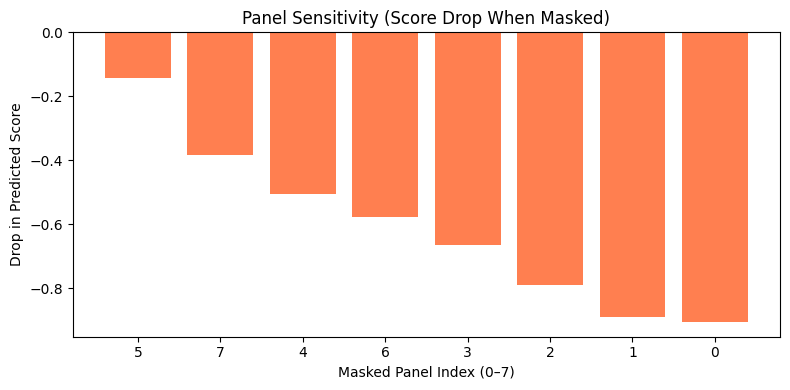

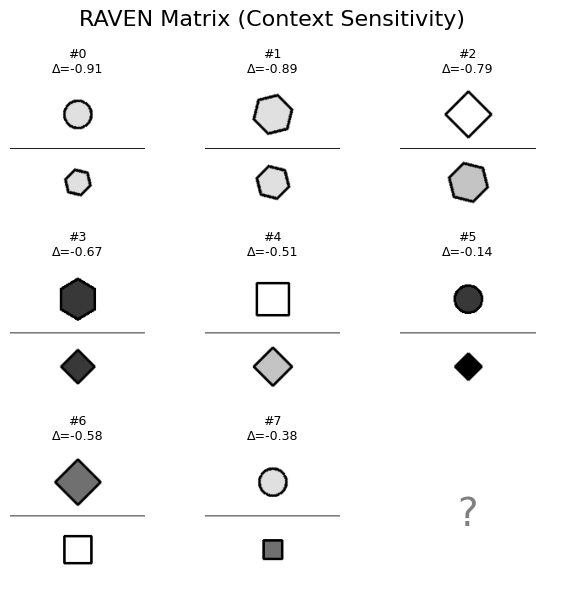

In [9]:
df = panel_sensitivity_analysis(model, images_tensor, blank_mode='zero')
images = data['image']  # from the .npz file, shape (16, H, W)
score_drops = df.sort_values('Panel Index')['Score Drop (impact)'].tolist()

visualize_raven_with_impact(images, score_drops)

In [10]:
def visualize_raven_context_importance(npz_path: str, save_path: str = None):
    # === Load model ===
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = DCNet().to(device)
    model.load_state_dict(torch.load("model_02.pth", map_location=device))
    model.eval()

    # === Load RAVEN sample ===
    data = np.load(npz_path)
    images = data['image']
    correct = int(data['target'])

    # === Resize and convert ===
    images_resized = np.stack([cv2.resize(img, (96, 96), interpolation=cv2.INTER_NEAREST) for img in images])
    tf = ToTensor()
    images_tensor = tf(images_resized).unsqueeze(0).to(device)

    # === Get base prediction ===
    with torch.no_grad():
        base_scores = model(images_tensor)[0]
        pred_idx = torch.argmax(base_scores).item()
        base_score = base_scores[pred_idx].item()

    # === Compute panel influence ===
    drops = []
    for i in range(8):  # Only context panels
        perturbed = images_tensor.clone()
        perturbed[0, i] = 0  # Zero out panel i

        with torch.no_grad():
            new_score = model(perturbed)[0, pred_idx].item()
            drop = base_score - new_score
            drops.append(round(drop, 5))

    # === Plotting ===
    fig, axs = plt.subplots(3, 3, figsize=(8, 9))
    fig.suptitle("RAVEN Matrix — Context Importance (Blue → Red)", fontsize=16)

    norm = plt.Normalize(vmin=min(drops), vmax=max(drops))
    cmap = cm.get_cmap("coolwarm")

    for i in range(9):
        ax = axs[i // 3, i % 3]
        ax.axis('off')

        if i < 8:
            impact = drops[i]
            color = cmap(norm(impact))
            ax.imshow(images[i], cmap='gray')
            rect = patches.Rectangle((0, 0), 1, 1, linewidth=4,
                                     edgecolor=color, facecolor='none',
                                     transform=ax.transAxes, clip_on=False)
            ax.add_patch(rect)
            ax.set_title(f"#{i}\nΔ={impact:.2f}", fontsize=10)
        else:
            ax.text(0.5, 0.5, "?", ha='center', va='center', fontsize=36, color='gray')

    # === Colorbar ===
    cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Score Drop (Panel Importance)', fontsize=12)

    plt.subplots_adjust(top=0.88, bottom=0.12)

    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved to: {save_path}")

    plt.show()

NameError: name 'cm' is not defined

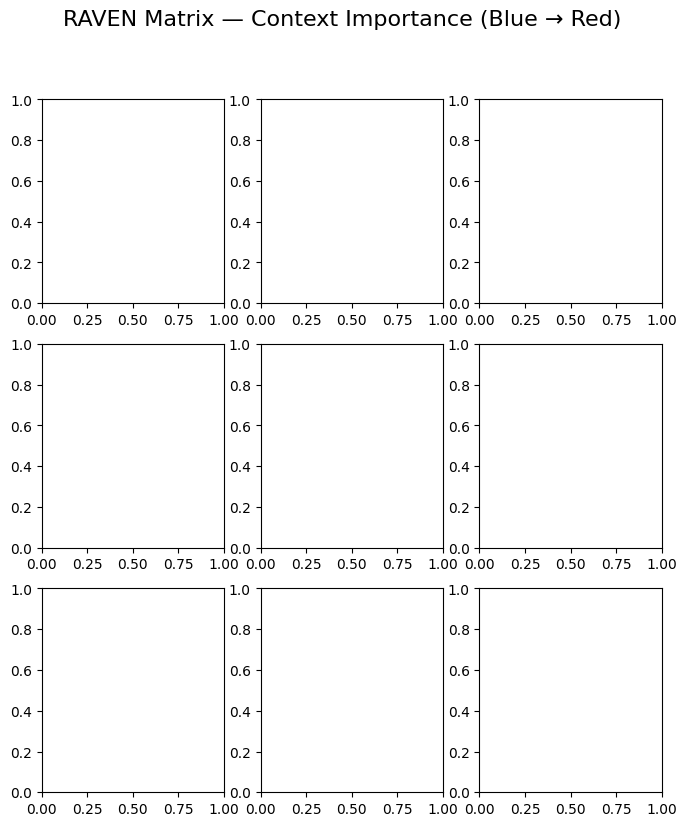

In [11]:
path = "dataset/RAVEN-10000/up_center_single_down_center_single/RAVEN_8669_test.npz"
visualize_raven_context_importance(path, "output_context_heatmap.png")